<a href="https://colab.research.google.com/github/saugkim/DeepLearningTrain/blob/main/Copy_of_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

04.11.2020 KIM

This is copy from Udacity course of "Intro to TensorFlow for Deep Learning"

Code source: Lesson 8 Topic "Time Series Forecasting"

Instructor: Aurélien Géron is a Machine Learning consultant, author of the best-selling O'Reilly book "Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow". A former Googler, he led YouTube's video classification team from 2013 to 2016. He was also a founder and CTO of Wifirst from 2002 to 2012, a leading Wireless ISP in France. Before this he worked as a consultant in a variety of domains: finance (JP Morgan and Société Générale), defense (Canada's DOD), and healthcare (blood transfusion). He also published a few technical books (on C++, WiFi, and Internet architectures), and he is a lecturer at the Dauphine University in Paris. He currently lives in New Zealand with his wife and 3 children.

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/udacity')

from tensorflow import keras
keras.backend.clear_session()

PROJECT_ROOT_DIR = "./drive/My Drive/Colab Notebooks/udacity"

In [1]:
# libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
keras = tf.keras

In [2]:
## Functions for Create Data
def plot_series(time, series, format="-", start=0, end=None, label=None):
    #plt.plot(figsize = (10,6))
    plt.plot(time[start:end],series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)
    #plt.show()
    
def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time<0.4, np.cos(season_time*2*np.pi), 1/np.exp(3*season_time))

def seasonality (time, period, amplitude=1, phase=0):
    season_time = ( (time+phase)%period )/period
    return amplitude * seasonal_pattern(season_time)

def white_noise(time, noise_level = 1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level


In [3]:
# Creating Input vector preparing for forecasting (create window)

# sequence to 1
def window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

# for rnn sequence to sequence
def seq2seq_window_dataset(series, window_size, 
                           batch_size=32, shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

# for stateful rnn, consecutive batch 
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

# for reset state every epoch
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()
        
# prediction
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

# evaluation
def get_mae(forecast, valid):
    errors = forecast - valid
    abs_errors = np.abs(errors)
    ret = abs_errors.mean()
    return keras.metrics.mean_absolute_error(valid, forecast).numpy()


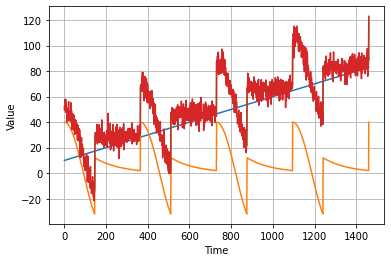

In [4]:
# Create Data using functions
time = np.arange(4*365 + 1)
baseline = 10
amplitude = 40
noise_level = 5

series = baseline + trend(time, 0.05)
plot_series(time, series)

series_with_seaonality = seasonality(time, 365, amplitude)
plot_series(time, series_with_seaonality)

series_with_trend_seasonality = series + series_with_seaonality
plot_series(time, series_with_trend_seasonality)

series_with_noise = series_with_trend_seasonality + white_noise(time, noise_level, seed=42)
plot_series(time, series_with_noise)


In [5]:
time = np.arange(4*365 + 1)
series = series_with_noise

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

x_train.shape, x_valid.shape

((1000,), (461,))

## Naive Forecast

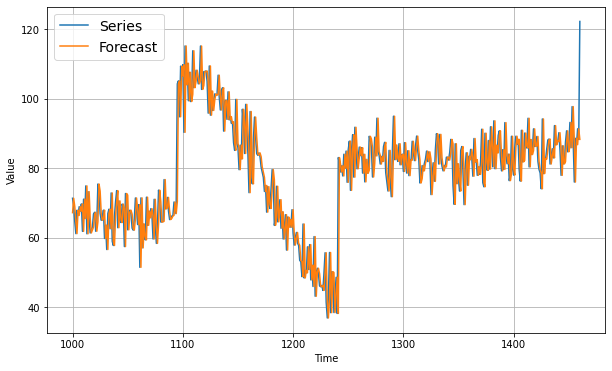

In [6]:
naive_forecast = series[split_time-1:-1]
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label = "Series")
plot_series(time_valid, naive_forecast, label = "Forecast")
plt.show()

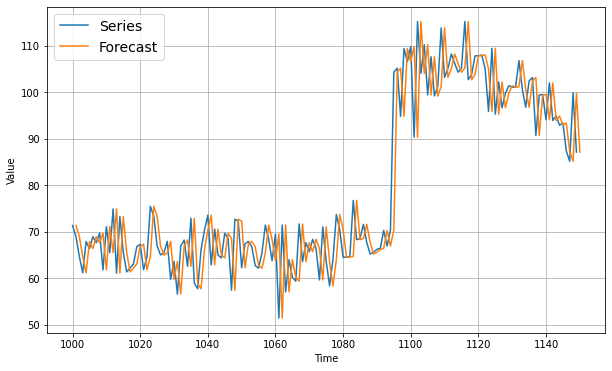

In [7]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150, label="Series")
plot_series(time_valid, naive_forecast, start=1, end=151, label="Forecast")

In [8]:
np.abs(naive_forecast - x_valid).mean()
get_mae(naive_forecast, x_valid)

5.9379085153216735

In [9]:
keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy()

5.9379085153216735

## Moving average (part3)

In [10]:
def moving_average_forecast(series, window_size):
    forecasts = []  #mean of the last window_size values
    for time in range(len(series) - window_size):
        forecast.append( series[time:(time+window_size)].mean())
    return forecasts

def moving_average_forecast(series, window_size):
    """ If window_size=1, then this is equivalent to naive forecast
    This implementation is *much* faster than the previous one """
    mov = np.cumsum(series)
    mov[window_size:] = mov[window_size:] - mov[:-window_size]
    return mov[window_size - 1:-1] / window_size


In [11]:
moving_average_forecast(series, 30).shape, series.shape

((1431,), (1461,))

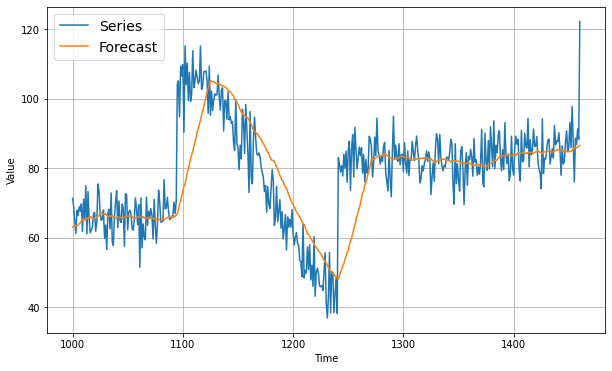

In [12]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, moving_avg, label="Forecast")

In [13]:
keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy()

7.1424185706207854

(1096,) (1096,) (1461,)
(1096,) (1096,)


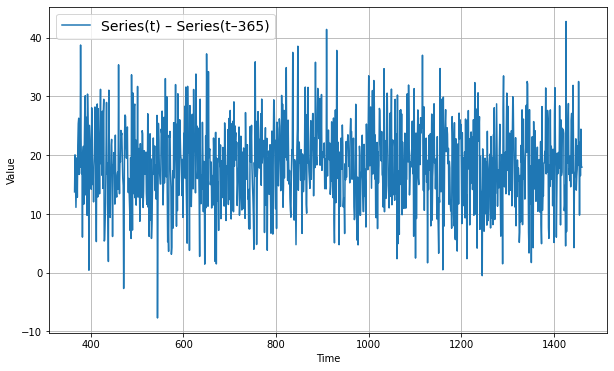

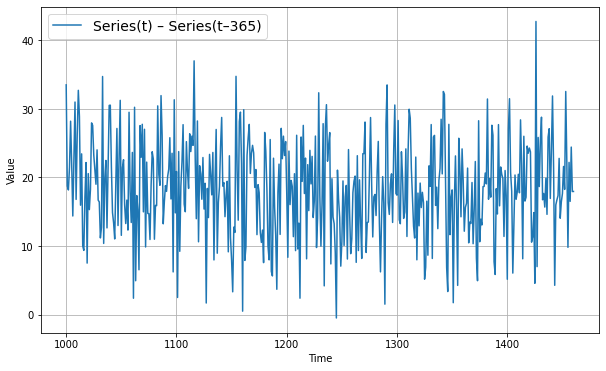

(461,) (461,)
[3 4 5 6 7 8 9] [0 1 2 3 4 5 6]


array([3, 3, 3, 3, 3, 3, 3])

In [14]:
diff_series = (series[365:] - series[:-365])
print(series[365:].shape, series[:-365].shape, series.shape)
diff_time = time[365:]
print(diff_series.shape, diff_time.shape)
plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series, label="Series(t) – Series(t–365)")
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plt.show()
print(time_valid.shape, diff_series[split_time-365:].shape)

x = np.arange(10)
x[3:], x[:-3]
print(x[3:], x[:-3])
x[3:] - x[:-3]

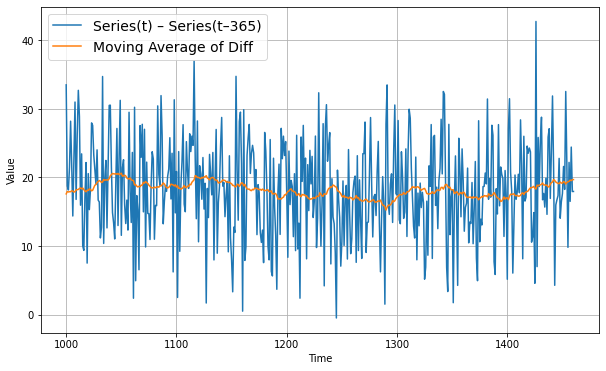

In [15]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:], label="Series(t) – Series(t–365)")
plot_series(time_valid, diff_moving_avg, label="Moving Average of Diff")
plt.show()

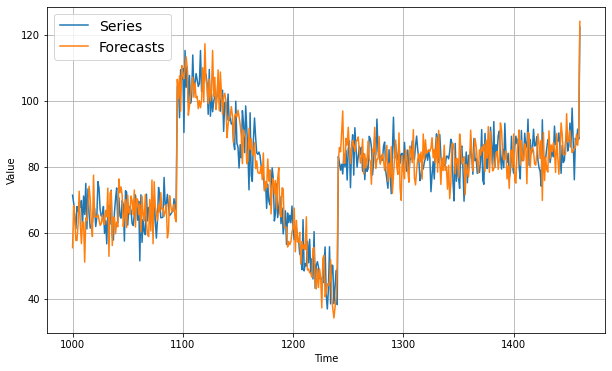

5.8393105629958955

In [16]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_past, label="Forecasts")
plt.show()
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy()

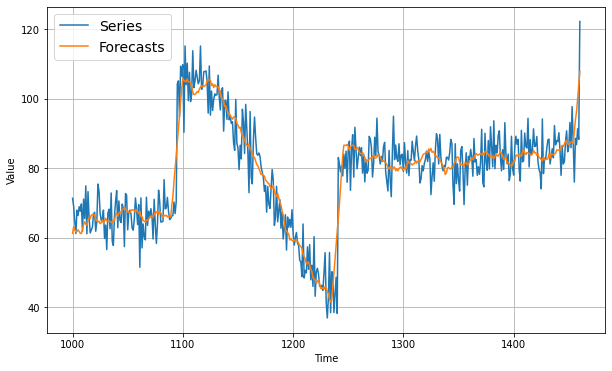

4.566859958970772

In [17]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-359], 11) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Series")
plot_series(time_valid, diff_moving_avg_plus_smooth_past, label="Forecasts")
plt.show()
keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy()

## Time Window (part4)

In [18]:
dataset = tf.data.Dataset.range(10)

# shift by 1
data = dataset.window(5, shift=1)
for window in data:
    for val in window:
        print(val.numpy(), end=" ")
    print()
    
# shift by 2, drop_remainder ON
data = dataset.window(5, shift=2, drop_remainder=True)
for window_dataset in data:
    for val in window_dataset:
        print(val.numpy(), end=" ")
    print()
    
# flat_map, shift by 1
data = dataset.window(5, shift=1, drop_remainder=True)
data = data.flat_map(lambda window: window.batch(5))
for window in data:
    print(window.numpy())

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 
0 1 2 3 4 
2 3 4 5 6 
4 5 6 7 8 
[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [19]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))

for x, y in dataset:
    print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [20]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
#dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)

for x, y in dataset:
    print(x.numpy(), y.numpy())

[4 5 6 7] [8]
[3 4 5 6] [7]
[5 6 7 8] [9]
[1 2 3 4] [5]
[2 3 4 5] [6]
[0 1 2 3] [4]


In [21]:
dataset = tf.data.Dataset.range(11)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(3).prefetch(1)

for x, y in dataset:
    print("x =", x.numpy())
    print("y =", y.numpy())

x = [[5 6 7 8]
 [3 4 5 6]
 [0 1 2 3]]
y = [[9]
 [7]
 [4]]
x = [[4 5 6 7]
 [6 7 8 9]
 [2 3 4 5]]
y = [[ 8]
 [10]
 [ 6]]
x = [[1 2 3 4]]
y = [[5]]


In [22]:
def window_dataset(series, window_size, batch_size=32, shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

## Forecasting with Machine learning (part5)

### Linear Model 

In [23]:
def get_learning_rate(train_set, output, window_size):
    
    model = keras.models.Sequential([
        keras.layers.Dense(output, input_shape=[window_size])
    ])
    lr_schedule = keras.callbacks.LearningRateScheduler(
            lambda epoch : 1e-6 * 10**(epoch/30))
    optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
    model.compile(loss = keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])
    history = model.fit(train_set, epochs=100, callbacks = [lr_schedule])
    
    plt.semilogx(history.history["lr"], history.history["loss"])
    plt.axis([1e-6, 1e-3, 0, 20])
    plt.show()
    return history


def get_best_model(train_set, valid_set, output, window_size, lr=1e-6):
    
    model = keras.models.Sequential([
        keras.layers.Dense(output, input_shape=[window_size])
    ])
    early_stopping = keras.callbacks.EarlyStopping(patience=10)
    optimizer = keras.optimizers.SGD(lr=lr, momentum=0.9)
    model.compile(loss = keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])
    model.fit(train_set, epochs=500,
              validation_data = valid_set,
              callbacks = [early_stopping])
    return model

In [24]:
import tensorflow as tf
keras = tf.keras

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
        keras.layers.Dense(1, input_shape=[window_size])
        ])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(), 
            optimizer = optimizer,
            metrics =['mae'] )

model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 0s 15ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/100
31/31 [==============================] - 0s 7ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/100
31/31 [==============================] - 0s 7ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 9.5716 - mae: 10.0561 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/100
31/31 [==============================] - 0s 7ms/step - l

In [25]:
import tensorflow as tf
keras = tf.keras

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
    keras.layers.Dense(1, input_shape=[window_size])
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch : 1e-6 * 10**(epoch/30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss = keras.losses.Huber(),
              optimizer = optimizer,
              metrics = ['mae'])
history = model.fit(train_set, epochs=100, callbacks = [lr_schedule])


Epoch 1/100
31/31 [==============================] - 0s 3ms/step - loss: 67.6867 - mae: 68.1863
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 52.3572 - mae: 52.8561
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 34.6465 - mae: 35.1446
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 17.6521 - mae: 18.1484
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 8.4604 - mae: 8.9488
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 7.9765 - mae: 8.4627
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 7.9201 - mae: 8.4035
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 7.8785 - mae: 8.3609
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 7.8191 - mae: 8.3014
Epoch 10/100
31/31 [==============================] - 0s 3ms/step - loss: 7.7701 - mae: 8.2547
Epoch 11/100
31/31 [==============================]

(1e-06, 0.001, 0.0, 20.0)

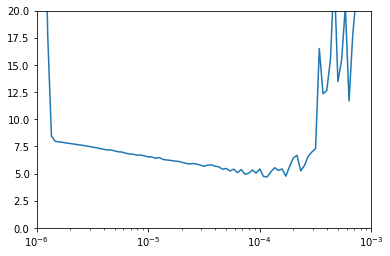

In [26]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [27]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
        keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile( loss = keras.losses.Huber(),
            optimizer = optimizer,
            metrics =['mae'])
early_stop = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500, 
          validation_data = valid_set, 
          callbacks =[early_stop])

Epoch 1/500
31/31 [==============================] - 0s 10ms/step - loss: 46.6813 - mae: 47.1784 - val_loss: 23.1475 - val_mae: 23.6473
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 11.9123 - mae: 12.4017 - val_loss: 10.6108 - val_mae: 11.0934
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 10.2063 - mae: 10.6947 - val_loss: 9.1115 - val_mae: 9.6013
Epoch 4/500
31/31 [==============================] - 0s 7ms/step - loss: 9.8053 - mae: 10.2898 - val_loss: 9.0103 - val_mae: 9.4965
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 9.7068 - mae: 10.1940 - val_loss: 8.9696 - val_mae: 9.4569
Epoch 6/500
31/31 [==============================] - 0s 8ms/step - loss: 9.5858 - mae: 10.0706 - val_loss: 9.2814 - val_mae: 9.7695
Epoch 7/500
31/31 [==============================] - 0s 8ms/step - loss: 9.5716 - mae: 10.0561 - val_loss: 8.7506 - val_mae: 9.2409
Epoch 8/500
31/31 [==============================] - 0s 8ms/step - l

In [28]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [29]:
model_forecast(model, series[split_time-window_size:-1], window_size).shape

(461, 1)

5.1662674

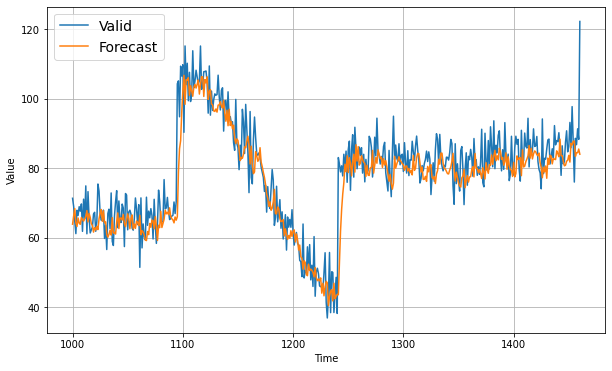

In [30]:
linear_forecasts = model_forecast(model, series[split_time - window_size:-1], window_size)[:,0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="Valid")
plot_series(time_valid, linear_forecasts, label="Forecast")

get_mae(linear_forecasts, x_valid)
keras.metrics.mean_absolute_error(x_valid, linear_forecasts).numpy()

### Dense Model Forecasting

In [31]:
# Get optimal learning rate 
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 4ms/step - loss: 43.8270 - mae: 44.3262
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 41.5210 - mae: 42.0202
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 38.6253 - mae: 39.1248
Epoch 4/100
31/31 [==============================] - 0s 4ms/step - loss: 35.3202 - mae: 35.8201
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 31.5905 - mae: 32.0903
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 27.4033 - mae: 27.9022
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 22.7830 - mae: 23.2804
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 17.7632 - mae: 18.2594
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 12.6771 - mae: 13.1682
Epoch 10/100
31/31 [==============================] - 0s 4ms/step - loss: 8.5974 - mae: 9.0856
Epoch 11/100
31/31 [=====================

(1e-07, 0.005, 0.0, 30.0)

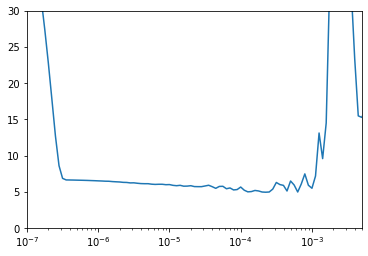

In [32]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [33]:
# Get best model with optimal learning rate
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500, 
          validation_data = valid_set,
          callbacks=[early_stopping])


Epoch 1/500
31/31 [==============================] - 0s 11ms/step - loss: 20.4049 - mae: 20.8986 - val_loss: 9.5125 - val_mae: 10.0037
Epoch 2/500
31/31 [==============================] - 0s 7ms/step - loss: 8.6179 - mae: 9.1027 - val_loss: 7.5804 - val_mae: 8.0585
Epoch 3/500
31/31 [==============================] - 0s 8ms/step - loss: 7.9849 - mae: 8.4702 - val_loss: 7.2411 - val_mae: 7.7189
Epoch 4/500
31/31 [==============================] - 0s 8ms/step - loss: 7.6780 - mae: 8.1603 - val_loss: 7.0971 - val_mae: 7.5798
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 7.4285 - mae: 7.9136 - val_loss: 6.6877 - val_mae: 7.1663
Epoch 6/500
31/31 [==============================] - 0s 8ms/step - loss: 7.2165 - mae: 7.6989 - val_loss: 6.7449 - val_mae: 7.2319
Epoch 7/500
31/31 [==============================] - 0s 10ms/step - loss: 7.0491 - mae: 7.5318 - val_loss: 6.3436 - val_mae: 6.8156
Epoch 8/500
31/31 [==============================] - 0s 8ms/step - loss: 6.902

In [34]:
dense_forecasts = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

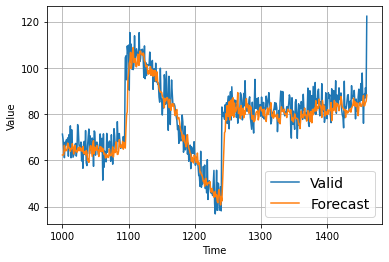

In [35]:
plt.plot(figsize=(10,6))
plot_series(time_valid, x_valid, label="Valid")
plot_series(time_valid, dense_forecasts, label="Forecast")

In [36]:
keras.metrics.mean_absolute_error(x_valid, dense_forecasts).numpy()

5.2025547

## Forecasting with an RNN (part6)

### Simple rnn

only for short-term pattern learning(batch size), stateless rnn, shuffled batch(no consequence batch to batch), batch size limit

In [37]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                        input_shape=[None]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 1s 66ms/step - loss: 50.2172 - mae: 50.7170
Epoch 2/100
8/8 [==============================] - 1s 65ms/step - loss: 23.0009 - mae: 23.4933
Epoch 3/100
8/8 [==============================] - 0s 62ms/step - loss: 19.2074 - mae: 19.7004
Epoch 4/100
8/8 [==============================] - 0s 56ms/step - loss: 16.9702 - mae: 17.4606
Epoch 5/100
8/8 [==============================] - 0s 54ms/step - loss: 15.4094 - mae: 15.8988
Epoch 6/100
8/8 [==============================] - 0s 60ms/step - loss: 14.7507 - mae: 15.2367
Epoch 7/100
8/8 [==============================] - 1s 65ms/step - loss: 14.3058 - mae: 14.7931
Epoch 8/100
8/8 [==============================] - 0s 54ms/step - loss: 14.0615 - mae: 14.5512
Epoch 9/100
8/8 [==============================] - 0s 56ms/step - loss: 13.7812 - mae: 14.2687
Epoch 10/100
8/8 [==============================] - 0s 52ms/step - loss: 13.5640 - mae: 14.0522
Epoch 11/100
8/8 [==============================]

(1e-07, 0.0001, 0.0, 30.0)

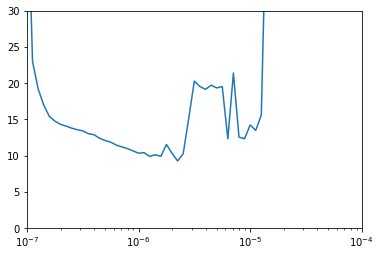

In [38]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [39]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size, batch_size=128)
valid_set = window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

early_stopping = keras.callbacks.EarlyStopping(patience=10)
model_checkpoint = keras.callbacks.ModelCheckpoint(
                    "my_checkpoint", save_best_only=True)
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=500, 
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint])


Epoch 1/500
      8/Unknown - 0s 54ms/step - loss: 56.6074 - mae: 57.1064WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_checkpoint/assets
8/8 [==============================] - 4s 492ms/step - loss: 56.6074 - mae: 57.1064 - val_loss: 14.7264 - val_mae: 15.2236
Epoch 2/500
8/8 [==============================] - 4s 493ms/step - loss: 33.8102 - mae: 34.3086 - val_loss: 13.5119 - val_mae: 14.0049
Epoch 3/500
8/8 [==============================] - 1s 71ms/step - loss: 29.4302 - mae: 29.9274 - val_loss: 39.4589 - val_mae: 39.9589
Epoch 4

5.3620768

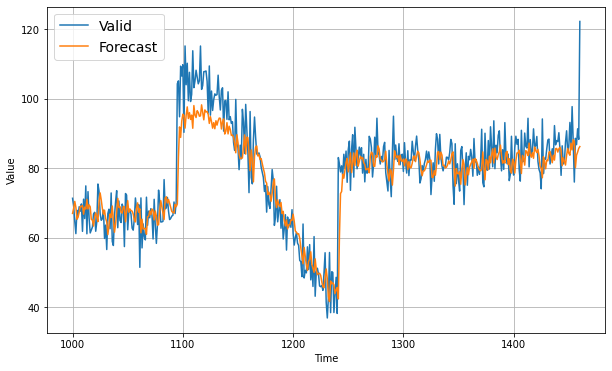

In [40]:
simple_rnn_forecasts = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="Valid")
plot_series(time_valid, simple_rnn_forecasts, label="Forecast")

keras.metrics.mean_absolute_error(x_valid, simple_rnn_forecasts).numpy()

### Sequence-to-Sequence Forecasting

In [41]:
def seq2seq_window_dataset(series, window_size, 
                           batch_size=32, shuffle_buffer=1000):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [42]:
import tensorflow as tf
for X_batch, Y_batch in seq2seq_window_dataset(tf.range(10), 5,
                                               batch_size=1):
    print("X:", X_batch.numpy())
    print("Y:", Y_batch.numpy())

X: [[[1]
  [2]
  [3]
  [4]
  [5]]]
Y: [[[2]
  [3]
  [4]
  [5]
  [6]]]
X: [[[0]
  [1]
  [2]
  [3]
  [4]]]
Y: [[[1]
  [2]
  [3]
  [4]
  [5]]]
X: [[[3]
  [4]
  [5]
  [6]
  [7]]]
Y: [[[4]
  [5]
  [6]
  [7]
  [8]]]
X: [[[4]
  [5]
  [6]
  [7]
  [8]]]
Y: [[[5]
  [6]
  [7]
  [8]
  [9]]]
X: [[[2]
  [3]
  [4]
  [5]
  [6]]]
Y: [[[3]
  [4]
  [5]
  [6]
  [7]]]


In [43]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
            lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 55ms/step - loss: 52.3618 - mae: 52.8614
Epoch 2/100
8/8 [==============================] - 0s 54ms/step - loss: 25.4934 - mae: 25.9891
Epoch 3/100
8/8 [==============================] - 0s 52ms/step - loss: 23.2908 - mae: 23.7849
Epoch 4/100
8/8 [==============================] - 0s 61ms/step - loss: 20.9775 - mae: 21.4704
Epoch 5/100
8/8 [==============================] - 0s 53ms/step - loss: 19.4448 - mae: 19.9359
Epoch 6/100
8/8 [==============================] - 0s 55ms/step - loss: 18.6296 - mae: 19.1188
Epoch 7/100
8/8 [==============================] - 0s 51ms/step - loss: 18.0603 - mae: 18.5499
Epoch 8/100
8/8 [==============================] - 0s 53ms/step - loss: 17.5912 - mae: 18.0800
Epoch 9/100
8/8 [==============================] - 0s 57ms/step - loss: 17.1803 - mae: 17.6696
Epoch 10/100
8/8 [==============================] - 0s 56ms/step - loss: 16.7664 - mae: 17.2553
Epoch 11/100
8/8 [==============================]

(1e-07, 0.0001, 0.0, 30.0)

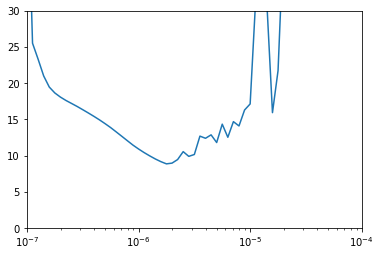

In [44]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 1e-4, 0, 30])

In [45]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(100, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(100, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

early_stopping = keras.callbacks.EarlyStopping(patience=10)
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=500, 
                    validation_data= valid_set,
                    callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 1s 113ms/step - loss: 54.1428 - mae: 54.6413 - val_loss: 17.9209 - val_mae: 18.4158
Epoch 2/500
8/8 [==============================] - 1s 82ms/step - loss: 34.1721 - mae: 34.6694 - val_loss: 20.5482 - val_mae: 21.0441
Epoch 3/500
8/8 [==============================] - 1s 85ms/step - loss: 27.5075 - mae: 28.0027 - val_loss: 37.8713 - val_mae: 38.3707
Epoch 4/500
8/8 [==============================] - 1s 71ms/step - loss: 21.0646 - mae: 21.5578 - val_loss: 25.2685 - val_mae: 25.7675
Epoch 5/500
8/8 [==============================] - 1s 72ms/step - loss: 17.1768 - mae: 17.6667 - val_loss: 15.3555 - val_mae: 15.8505
Epoch 6/500
8/8 [==============================] - 1s 73ms/step - loss: 15.0383 - mae: 15.5247 - val_loss: 9.4217 - val_mae: 9.9070
Epoch 7/500
8/8 [==============================] - 1s 70ms/step - loss: 13.9508 - mae: 14.4372 - val_loss: 9.1617 - val_mae: 9.6475
Epoch 8/500
8/8 [==============================] - 1s 72ms/step -

5.4588704

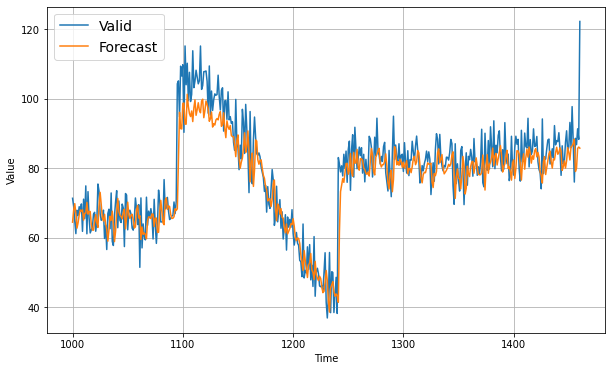

In [46]:
seq2seq_simple_rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
seq2seq_simple_rnn_forecast = seq2seq_simple_rnn_forecast[split_time - window_size:-1, -1, 0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="Valid")
plot_series(time_valid, seq2seq_simple_rnn_forecast, label="Forecast")

keras.metrics.mean_absolute_error(x_valid, seq2seq_simple_rnn_forecast).numpy()

## Forecast with stateful rnn (part7)

what is stateful rnn? for long-term pattern learning, batch size can be grown
consequently batch to batch, no shuffled, previous batch give effect to current batch, next batch is next sequence of current batch. each epoch reset state(reset callback needed), limit? yes, not remember

In [47]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [48]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [49]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 30))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 1s 37ms/step - loss: 105.9340 - mae: 106.4340
Epoch 2/100
33/33 [==============================] - 1s 37ms/step - loss: 70.8572 - mae: 71.3572
Epoch 3/100
33/33 [==============================] - 1s 44ms/step - loss: 39.8080 - mae: 40.3048
Epoch 4/100
33/33 [==============================] - 1s 36ms/step - loss: 27.3450 - mae: 27.8404
Epoch 5/100
33/33 [==============================] - 1s 40ms/step - loss: 24.4956 - mae: 24.9892
Epoch 6/100
33/33 [==============================] - 1s 35ms/step - loss: 23.2601 - mae: 23.7517
Epoch 7/100
33/33 [==============================] - 1s 36ms/step - loss: 22.0604 - mae: 22.5533
Epoch 8/100
33/33 [==============================] - 1s 34ms/step - loss: 20.8543 - mae: 21.3463
Epoch 9/100
33/33 [==============================] - 1s 34ms/step - loss: 19.8307 - mae: 20.3245
Epoch 10/100
33/33 [==============================] - 1s 40ms/step - loss: 18.9399 - mae: 19.4319
Epoch 11/100
33/33 [=======

(1e-08, 0.0001, 0.0, 30.0)

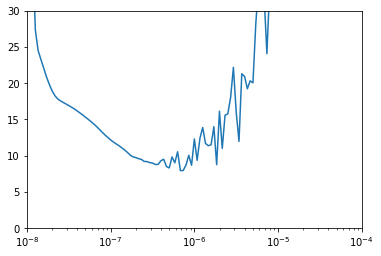

In [50]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [51]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.SimpleRNN(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
                "my_checkpoint7.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 2s 52ms/step - loss: 60.2499 - mae: 60.7478 - val_loss: 25.0218 - val_mae: 25.5179
Epoch 2/500
33/33 [==============================] - 2s 50ms/step - loss: 21.4714 - mae: 21.9618 - val_loss: 10.9142 - val_mae: 11.4074
Epoch 3/500
33/33 [==============================] - 1s 41ms/step - loss: 18.7249 - mae: 19.2166 - val_loss: 12.0569 - val_mae: 12.5479
Epoch 4/500
33/33 [==============================] - 1s 39ms/step - loss: 17.5231 - mae: 18.0143 - val_loss: 10.4488 - val_mae: 10.9391
Epoch 5/500
33/33 [==============================] - 1s 43ms/step - loss: 16.6983 - mae: 17.1891 - val_loss: 9.9581 - val_mae: 10.4500
Epoch 6/500
33/33 [==============================] - 1s 44ms/step - loss: 15.9090 - mae: 16.3984 - val_loss: 9.1539 - val_mae: 9.6415
Epoch 7/500
33/33 [==============================] - 1s 38ms/step - loss: 15.2155 - mae: 15.7027 - val_loss: 8.3393 - val_mae: 8.8249
Epoch 8/500
33/33 [==============================] - 

In [52]:
model = keras.models.load_model("my_checkpoint7.h5")
model.reset_states()
stateful_rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
stateful_rnn_forecast = stateful_rnn_forecast[0, split_time - 1:-1, 0]

6.2778373

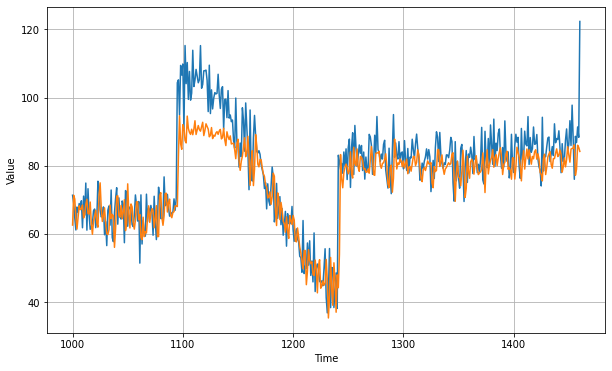

In [53]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, stateful_rnn_forecast)

keras.metrics.mean_absolute_error(x_valid, stateful_rnn_forecast).numpy()

## Forecasting with an LSTM (part8)

### LSTM RNN Forecasting

for learning long-term pattern, long-term state vector (forget gate, on or off)

In [54]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-8 * 10**(epoch / 20))
reset_states = ResetStatesCallback()
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100,
                    callbacks=[lr_schedule, reset_states])

Epoch 1/100
33/33 [==============================] - 0s 12ms/step - loss: 90.9191 - mae: 91.4191
Epoch 2/100
33/33 [==============================] - 0s 12ms/step - loss: 83.8978 - mae: 84.3978
Epoch 3/100
33/33 [==============================] - 0s 12ms/step - loss: 75.4974 - mae: 75.9974
Epoch 4/100
33/33 [==============================] - 0s 12ms/step - loss: 66.0676 - mae: 66.5676
Epoch 5/100
33/33 [==============================] - 0s 12ms/step - loss: 55.5131 - mae: 56.0131
Epoch 6/100
33/33 [==============================] - 0s 13ms/step - loss: 43.7599 - mae: 44.2597
Epoch 7/100
33/33 [==============================] - 0s 13ms/step - loss: 30.7909 - mae: 31.2900
Epoch 8/100
33/33 [==============================] - 0s 13ms/step - loss: 17.1478 - mae: 17.6436
Epoch 9/100
33/33 [==============================] - 0s 13ms/step - loss: 10.0311 - mae: 10.5178
Epoch 10/100
33/33 [==============================] - 0s 12ms/step - loss: 10.0607 - mae: 10.5524
Epoch 11/100
33/33 [=========

(1e-08, 0.0001, 0.0, 30.0)

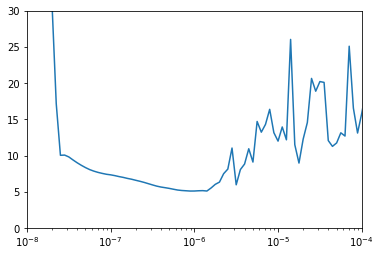

In [55]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [56]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = sequential_window_dataset(x_train, window_size)
valid_set = sequential_window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                         batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])

optimizer = keras.optimizers.SGD(lr=5e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

reset_states = ResetStatesCallback()
model_checkpoint = keras.callbacks.ModelCheckpoint(
        "my_checkpoint8.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)

model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping, model_checkpoint, reset_states])

Epoch 1/500
33/33 [==============================] - 1s 38ms/step - loss: 30.0122 - mae: 30.5050 - val_loss: 13.0810 - val_mae: 13.5746
Epoch 2/500
33/33 [==============================] - 1s 23ms/step - loss: 15.3618 - mae: 15.8570 - val_loss: 10.0991 - val_mae: 10.5941
Epoch 3/500
33/33 [==============================] - 1s 21ms/step - loss: 10.9284 - mae: 11.4173 - val_loss: 11.2192 - val_mae: 11.7083
Epoch 4/500
33/33 [==============================] - 1s 16ms/step - loss: 9.8165 - mae: 10.3052 - val_loss: 12.2806 - val_mae: 12.7757
Epoch 5/500
33/33 [==============================] - 1s 16ms/step - loss: 7.8424 - mae: 8.3317 - val_loss: 9.6437 - val_mae: 10.1336
Epoch 6/500
33/33 [==============================] - 1s 16ms/step - loss: 7.1708 - mae: 7.6561 - val_loss: 10.6124 - val_mae: 11.1036
Epoch 7/500
33/33 [==============================] - 1s 16ms/step - loss: 5.9200 - mae: 6.4041 - val_loss: 10.1595 - val_mae: 10.6522
Epoch 8/500
33/33 [==============================] - 1s 

In [57]:
model = keras.models.load_model("my_checkpoint8.h5")
lstm_forecast = model.predict(series[np.newaxis, :, np.newaxis])
lstm_forecast = lstm_forecast[0, split_time - 1:-1, 0]

5.907984

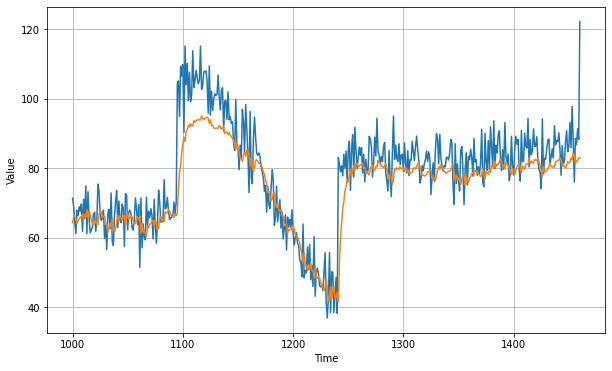

In [58]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lstm_forecast)

keras.metrics.mean_absolute_error(x_valid, lstm_forecast).numpy()

## Forecasting with CNN (part9)

CNN, kernal size and number(multivariant) of kernal(=filter), causal padding, stride, (WaveNet, dilation rate)

### preprocessing with cnn layer, lstm

In [59]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# stateless train set -no consecutive batch = shuffled
window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size,
                                   batch_size=128)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5,
                       strides=1, padding="causal",
                       activation ='relu',
                       input_shape=[None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 19ms/step - loss: 87.8346 - mae: 88.3341
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 87.1197 - mae: 87.6191
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 85.9241 - mae: 86.4234
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 84.3720 - mae: 84.8713
Epoch 5/100
8/8 [==============================] - 0s 16ms/step - loss: 82.4702 - mae: 82.9696
Epoch 6/100
8/8 [==============================] - 0s 16ms/step - loss: 80.2434 - mae: 80.7427
Epoch 7/100
8/8 [==============================] - 0s 15ms/step - loss: 77.7459 - mae: 78.2453
Epoch 8/100
8/8 [==============================] - 0s 17ms/step - loss: 75.0957 - mae: 75.5952
Epoch 9/100
8/8 [==============================] - 0s 16ms/step - loss: 72.4508 - mae: 72.9503
Epoch 10/100
8/8 [==============================] - 0s 15ms/step - loss: 69.8938 - mae: 70.3934
Epoch 11/100
8/8 [==============================]

(1e-08, 0.0001, 0.0, 30.0)

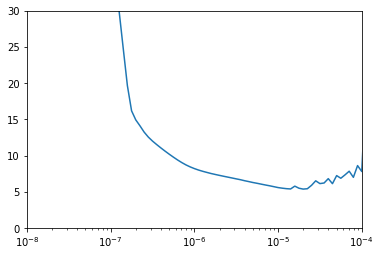

In [60]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [61]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=32, kernel_size=5, 
                       strides=1, padding='causal',
                       activation='relu',
                       input_shape= [None, 1]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200)    
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss = keras.losses.Huber(),
             optimizer = optimizer,
             metrics=['mae'])

model_checkpoint = keras.callbacks.ModelCheckpoint(
        "my_checkpoint9.h5", save_best_only=True)
early_stopping = keras.callbacks.EarlyStopping(patience=50)

model.fit(train_set, epochs = 500,
         validation_data = valid_set,
         callbacks = [model_checkpoint, early_stopping])

Epoch 1/500
8/8 [==============================] - 1s 128ms/step - loss: 56.9010 - mae: 57.4001 - val_loss: 28.7748 - val_mae: 29.2719
Epoch 2/500
8/8 [==============================] - 0s 28ms/step - loss: 26.1449 - mae: 26.6407 - val_loss: 38.9232 - val_mae: 39.4212
Epoch 3/500
8/8 [==============================] - 0s 29ms/step - loss: 17.3629 - mae: 17.8584 - val_loss: 30.1022 - val_mae: 30.6010
Epoch 4/500
8/8 [==============================] - 0s 31ms/step - loss: 12.0091 - mae: 12.4990 - val_loss: 24.5627 - val_mae: 25.0602
Epoch 5/500
8/8 [==============================] - 0s 35ms/step - loss: 9.9288 - mae: 10.4167 - val_loss: 18.8857 - val_mae: 19.3824
Epoch 6/500
8/8 [==============================] - 0s 35ms/step - loss: 8.8391 - mae: 9.3253 - val_loss: 16.0114 - val_mae: 16.5063
Epoch 7/500
8/8 [==============================] - 0s 33ms/step - loss: 8.0840 - mae: 8.5699 - val_loss: 12.5160 - val_mae: 13.0055
Epoch 8/500
8/8 [==============================] - 0s 33ms/step - 

In [62]:
model = keras.models.load_model('my_checkpoint9.h5')

cnn_lstm_forecast = model_forecast(model, series[:,  np.newaxis], window_size)
cnn_lstm_forecast = cnn_lstm_forecast[split_time - window_size:-1, -1, 0]


5.112796170400738

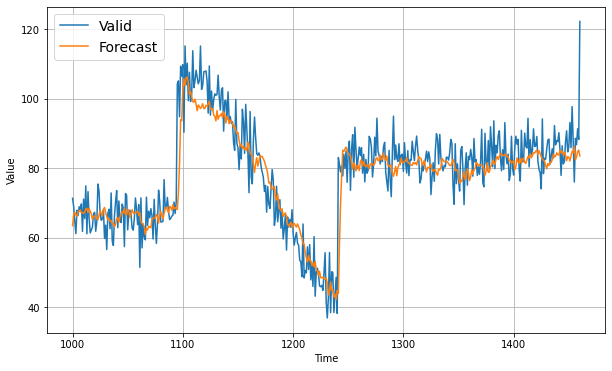

In [63]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid, label="Valid")
plot_series(time_valid, cnn_lstm_forecast, label ="Forecast")

get_mae(x_valid, cnn_lstm_forecast)

### fully Convolutional Forecasting

In [64]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size=64
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in [1, 2, 4, 8 ,16, 32]:
    model.add(keras.layers.Conv1D(filters=32, 
                        kernel_size=2,
                        strides=1, 
                        padding='causal',
                        activation='relu',
                        dilation_rate = dilation_rate))

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

lr_schedule = keras.callbacks.LearningRateScheduler(
        lambda epoch: 1e-4 * 10 **(epoch/30))
optimizer = keras.optimizers.Adam(lr=1e-4)
model.compile(loss = keras.losses.Huber(),
             optimizer = optimizer,
             metrics =['mae'])

history = model.fit(train_set, epochs=100, callbacks = [lr_schedule])


Epoch 1/100
8/8 [==============================] - 0s 34ms/step - loss: 42.2341 - mae: 42.7330
Epoch 2/100
8/8 [==============================] - 0s 9ms/step - loss: 41.8293 - mae: 42.3284
Epoch 3/100
8/8 [==============================] - 0s 10ms/step - loss: 41.4367 - mae: 41.9357
Epoch 4/100
8/8 [==============================] - 0s 10ms/step - loss: 41.0108 - mae: 41.5098
Epoch 5/100
8/8 [==============================] - 0s 10ms/step - loss: 40.4787 - mae: 40.9776
Epoch 6/100
8/8 [==============================] - 0s 10ms/step - loss: 39.7341 - mae: 40.2328
Epoch 7/100
8/8 [==============================] - 0s 10ms/step - loss: 38.5883 - mae: 39.0871
Epoch 8/100
8/8 [==============================] - 0s 9ms/step - loss: 36.6836 - mae: 37.1822
Epoch 9/100
8/8 [==============================] - 0s 11ms/step - loss: 33.3644 - mae: 33.8629
Epoch 10/100
8/8 [==============================] - 0s 10ms/step - loss: 27.9449 - mae: 28.4427
Epoch 11/100
8/8 [==============================] -

(0.0001, 0.1, 0.0, 30.0)

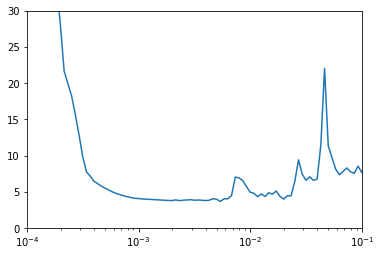

In [65]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-1, 0, 30])

In [66]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 64
train_set = seq2seq_window_dataset(x_train, window_size, batch_size=128)
valid_set = seq2seq_window_dataset(x_valid, window_size, batch_size=128)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))

for dilation_rate in [1, 2, 4, 8, 16, 32]:
    model.add(keras.layers.Conv1D(filters=64,
                                  kernel_size=2,
                                  strides=1,
                                  padding='causal',
                                  activation ='relu',
                                  dilation_rate=dilation_rate ))

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))

early_stopping = keras.callbacks.EarlyStopping(patience=50)
model_checkpoint = keras.callbacks.ModelCheckpoint(
            "my_checkpoint.h5", save_best_only = True)
optimizer = keras.optimizers.Adam(lr=3e-4)

model.compile(loss = keras.losses.Huber(),
             optimizer= optimizer,
             metrics=['mae'])

history = model.fit(train_set, epochs = 500,
                    validation_data = valid_set,
                    callbacks =[early_stopping, model_checkpoint])

Epoch 1/500
8/8 [==============================] - 1s 122ms/step - loss: 39.2086 - mae: 39.7073 - val_loss: 68.5757 - val_mae: 69.0757
Epoch 2/500
8/8 [==============================] - 0s 32ms/step - loss: 34.2243 - mae: 34.7229 - val_loss: 54.0967 - val_mae: 54.5967
Epoch 3/500
8/8 [==============================] - 0s 39ms/step - loss: 24.5304 - mae: 25.0271 - val_loss: 30.6288 - val_mae: 31.1253
Epoch 4/500
8/8 [==============================] - 0s 37ms/step - loss: 18.8119 - mae: 19.3073 - val_loss: 30.0073 - val_mae: 30.5051
Epoch 5/500
8/8 [==============================] - 0s 32ms/step - loss: 16.2846 - mae: 16.7788 - val_loss: 22.5747 - val_mae: 23.0689
Epoch 6/500
8/8 [==============================] - 0s 32ms/step - loss: 13.1357 - mae: 13.6258 - val_loss: 16.5848 - val_mae: 17.0759
Epoch 7/500
8/8 [==============================] - 0s 33ms/step - loss: 9.9886 - mae: 10.4760 - val_loss: 11.8201 - val_mae: 12.3064
Epoch 8/500
8/8 [==============================] - 0s 32ms/ste

In [67]:
model = keras.models.load_model("my_checkpoint.h5")

full_cnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
full_cnn_forecast = full_cnn_forecast[split_time - window_size:-1, -1, 0]

<tf.Tensor: shape=(), dtype=float32, numpy=4.5492864>

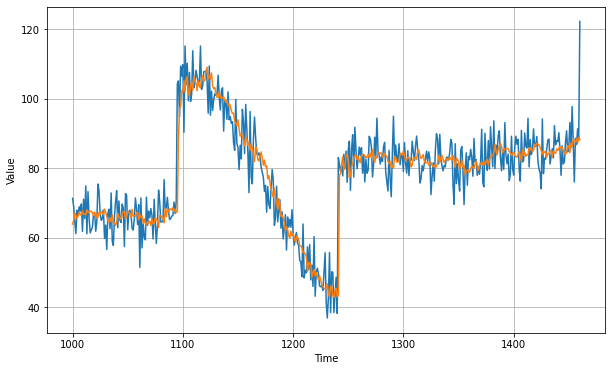

In [68]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, full_cnn_forecast)

keras.metrics.mean_absolute_error(x_valid, full_cnn_forecast)




In [69]:
get_mae(x_valid, full_cnn_forecast)

4.549286472810326